# Projet 6 : Classifiez automatiquement des biens de consommation

# Problématique
La classification manuelle des produits selon leur catégorie est difficile et enclin à des erreurs.
# Objectif

L'objectif est ici de construire et d'analyser des graphiques de clustering afin d’en déduire ou pas, à l’aide des descriptions ou des images, la faisabilité de regrouper automatiquement des produits de même catégorie.
Il sera ensuite question de réaliser une mesure pour confirmer ton analyse visuelle, en calculant la similarité entre les catégories réelles et les catégories issues d’une segmentation en clusters.


# Source des données
Le dataset utilisé pour ce projet est "flipkart_com-ecommerce_sample_1050". Il contient des informations sur 1050 produits vendus sur Flipkart, un site de e-commerce en Inde.

# Sommaire:
-  1 - Librairies
-  2 - Jeu de données
-  3 - EDA
-  4 - Prétraitement ds images
-  5 - Extraction de features (BoVW)
     - SIFT
     - Réduction de dimension T-SNE 
     - Kmeans + ARI.
     - Analyse graphique




# 1 - Librairies

In [62]:
 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import pickle
import os
import time
import random

# Traitement images
import PIL
from PIL import Image, ImageOps, ImageFilter
import cv2
import imghdr

from scipy.ndimage import gaussian_filter

import warnings
warnings.filterwarnings('ignore')


# 2 - Jeu de données


In [63]:
cleaned_df = pd.read_csv('cleaned_df.csv')

In [64]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          1050 non-null   int64 
 1   uniq_id             1050 non-null   object
 2   image               1050 non-null   object
 3   clean_product_name  1050 non-null   object
 4   clean_description   1050 non-null   object
 5   clean_categories    1050 non-null   object
dtypes: int64(1), object(5)
memory usage: 49.3+ KB


In [65]:
cleaned_df.drop(columns=['Unnamed: 0', 'uniq_id'], inplace=True)

In [66]:
cleaned_df = cleaned_df.rename(columns={'clean_product_name': 'product_name', 
                                        'clean_description': 'description', 
                                        'clean_categories': "categorie"})

cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image         1050 non-null   object
 1   product_name  1050 non-null   object
 2   description   1050 non-null   object
 3   categorie     1050 non-null   object
dtypes: object(4)
memory usage: 32.9+ KB


In [67]:
image_df = cleaned_df[["image", "categorie"]].copy()


In [68]:
image_df.shape

(1050, 2)

In [69]:
image_df.head()

,image,categorie
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,home furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,baby care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,baby care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,home furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,home furnishing


- ### Accès aux images

In [70]:
image_path = '/Users/danongohou/Desktop/P6_Bis/Images/'


- ### Liaison des images à leurs identifiants

In [71]:
image_df['image_loc'] = [image_path + row for row in image_df['image']]

- ### Dataset utile (image)

In [72]:
image_df = image_df[["image", 'image_loc', "categorie"]]
image_df.head()

,image,image_loc,categorie
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,/Users/danongohou/Desktop/P6_Bis/Images/55b85e...,home furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,/Users/danongohou/Desktop/P6_Bis/Images/7b72c9...,baby care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,/Users/danongohou/Desktop/P6_Bis/Images/64d5d4...,baby care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,/Users/danongohou/Desktop/P6_Bis/Images/d4684d...,home furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,/Users/danongohou/Desktop/P6_Bis/Images/6325b6...,home furnishing


In [73]:
image_df.to_csv("image_data.csv")

# 3 - EDA 

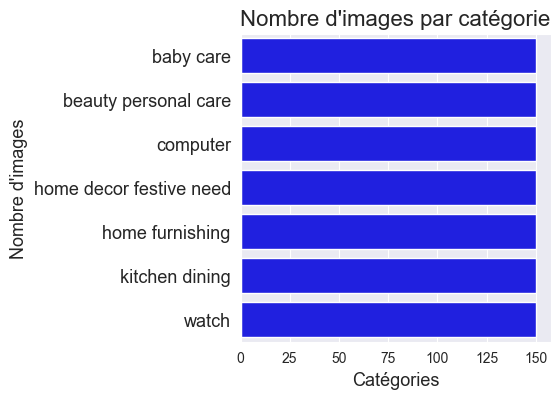

In [76]:
nb_image_categorie = image_df.groupby('categorie').agg({'image' : 'count'})

plt.figure(figsize=(4, 4))
sns.set_style('darkgrid')
sns.barplot(y=nb_image_categorie.index, x=nb_image_categorie.image,
            data=nb_image_categorie, color='blue')
plt.title('Nombre d\'images par catégorie', fontsize=16)
plt.xlabel('Catégories', fontsize=13)
plt.ylabel('Nombre d\'images', fontsize=13)
plt.yticks(fontsize=13)

plt.show()

- ### Voir quelques images

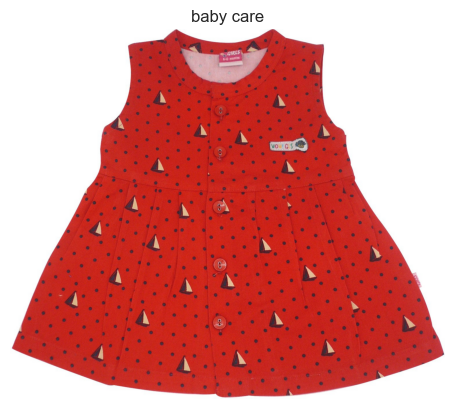

In [77]:
# Sélectionner une image aléatoire
random_image = random.choice(image_df['image_loc'])
category = image_df.loc[image_df['image_loc'] == random_image, 'categorie'].values[0]

# Afficher l'image
img = plt.imread(random_image)
plt.imshow(img)
plt.title(category)
plt.axis('off')
plt.show()

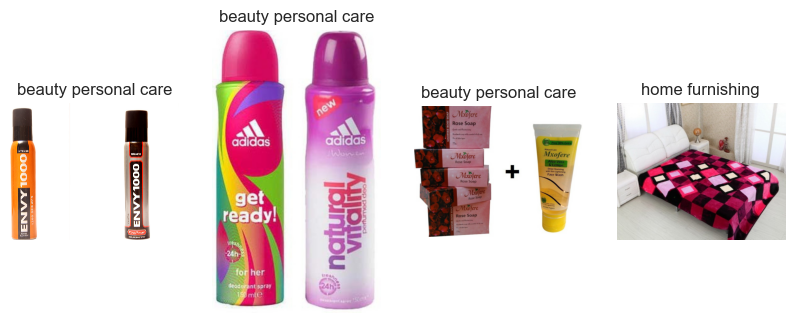

In [78]:
# Sélection de 4 images au hasard
import random

# Sélectionner 4 images aléatoires
random_images = random.sample(list(image_df.index), 4)

# Afficher les images
fig, axs = plt.subplots(1, 4, figsize=(10,10))
for i, idx in enumerate(random_images):
    img = plt.imread(image_df.loc[idx, 'image_loc'])
    category = image_df.loc[idx, 'categorie']
    axs[i].imshow(img)
    axs[i].set_title(category)
    axs[i].axis('off')
plt.show()


- ### Largeur des images

<Figure size 600x400 with 0 Axes>

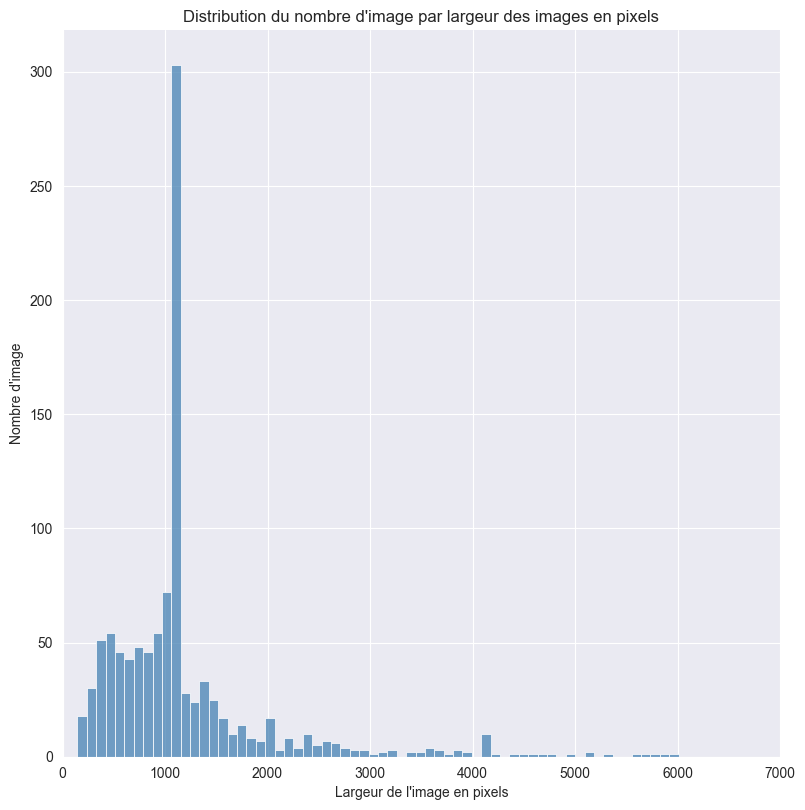

In [79]:
# Largeur des images
image_df['Largeur_image'] = [Image.open(row).size[0] for row in image_df['image_loc']]

plt.figure(figsize=(6, 4))
# Répartition du nombre d'images par taille de l'image en pixel
sns.displot(image_df['Largeur_image'], color='SteelBlue', height=8)
plt.title('Distribution du nombre d\'image par largeur des images en pixels')
plt.xlim(0, 7000)
plt.xlabel('Largeur de l\'image en pixels')
plt.ylabel('Nombre d\'image')
plt.show()

- ### Hauteur des images

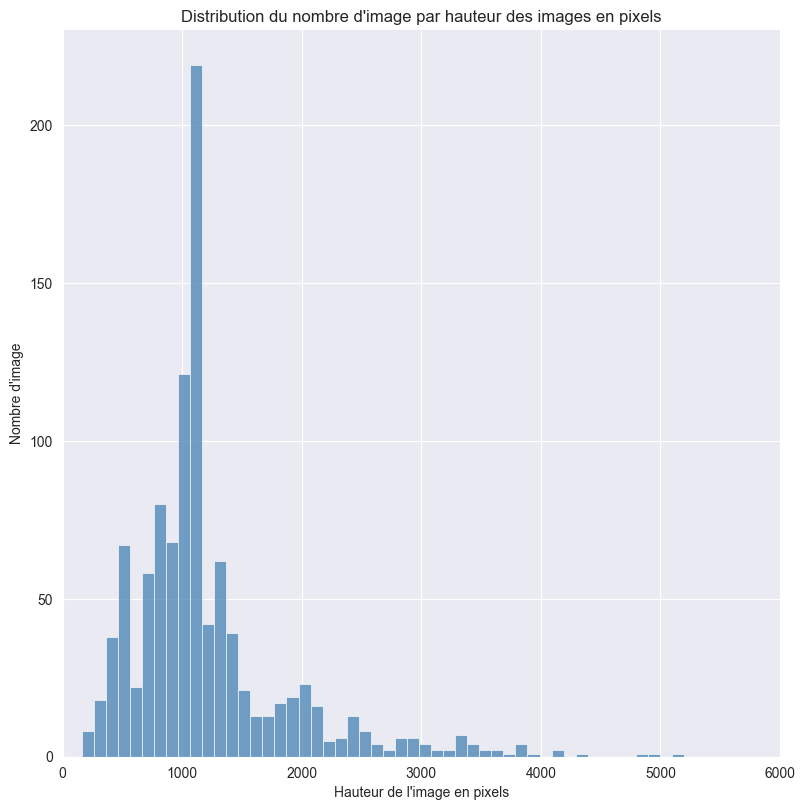

In [80]:
# Hauteur des images
image_df['Hauteur_image'] = [Image.open(row).size[1] for row in image_df['image_loc']]

# Répartition du nombre d'images par taille de l'image en pixel
sns.displot(image_df['Hauteur_image'], color='SteelBlue', height=8)
plt.title('Distribution du nombre d\'image par hauteur des images en pixels')
plt.xlim(0, 6000)
plt.xlabel('Hauteur de l\'image en pixels')
plt.ylabel('Nombre d\'image')
plt.show()

- ### Taille des images

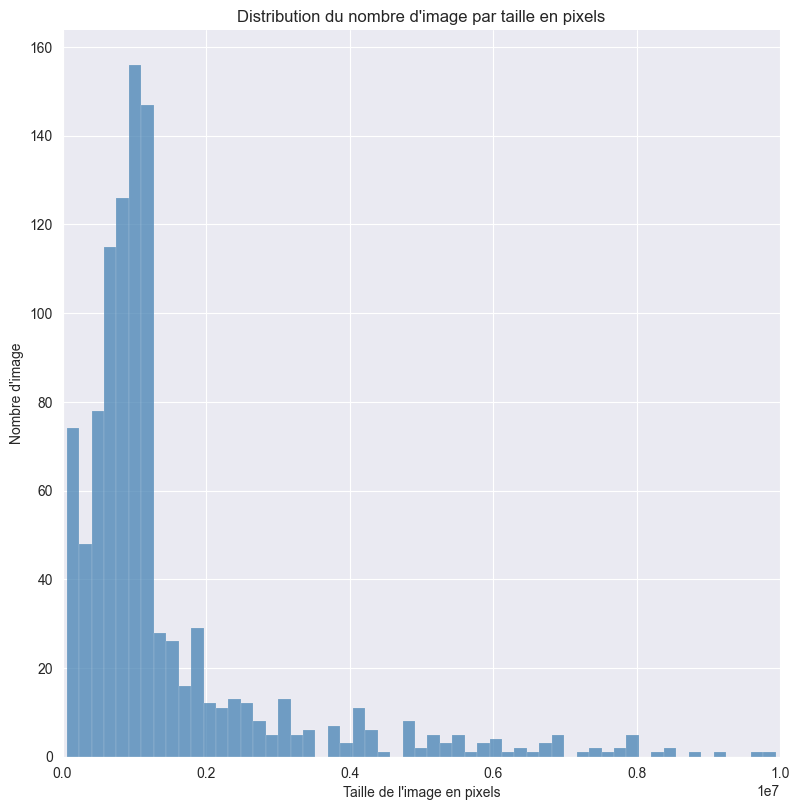

In [81]:
# Taille des images
image_df['Taille_image'] = [(Image.open(row).size[0] * Image.open(row).size[1])
                      for row in image_df['image_loc']]

# Répartition du nombre d'images par taille de l'image en pixel
sns.displot(image_df['Taille_image'], color='SteelBlue', height=8)
plt.title('Distribution du nombre d\'image par taille en pixels')
plt.xlim(0, 10000000)
plt.xlabel('Taille de l\'image en pixels')
plt.ylabel('Nombre d\'image')
plt.show()



In [82]:

image_df = pd.read_csv('image_data.csv')

In [83]:
from PIL import Image
import pandas as pd

# Initialiser un dictionnaire pour stocker les comptes de format
format_counts = {}

# Boucle à travers chaque image et compter le format
for index, row in image_df.iterrows():
    image_path = row['image_loc']
    with Image.open(image_path) as img:
        format_counts[img.format] = format_counts.get(img.format, 0) + 1

# Convertir le dictionnaire en DataFrame et afficher
format_counts_df = pd.DataFrame.from_dict(format_counts, orient='index', columns=['Nombre d\'images'])
format_counts_df.index.name = 'Format'
print(format_counts_df)


        Nombre d'images
Format                 
JPEG               1050


# 4 - Prétraitement des images

In [84]:
import numpy as np
import os
import cv2
from PIL import Image, ImageOps

# Chemin vers le dossier d'entrée contenant les images
input_path = '/Users/danongohou/Desktop/P6_Bis/Images/'
# Chemin vers le dossier de sortie
output_path = '/Users/danongohou/Desktop/P6_Bis/Processed_Images/'

# Créer le dossier de sortie s'il n'existe pas
if not os.path.exists(output_path):
    os.makedirs(output_path)
    
# Parcourir toutes les images dans le dossier d'entrée
for filename in os.listdir(input_path):
    # Vérifier si le fichier est une image
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Charger l'image avec OpenCV
        image = cv2.imread(os.path.join(input_path, filename))
        # Correction de l'exposition avec PILS
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        image = ImageOps.autocontrast(image)
        image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        # Conversion en niveau de gris de l'image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Equalization de l'histogramme de l'image
        image = cv2.equalizeHist(image)
        # Correction du contraste 
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(3,3))
        image = clahe.apply(image)
        # Réduction de bruit avec OpenCV
        image = cv2.fastNlMeansDenoising(image, h=10)
        # Ajout de BLUR avec OpenCV
        image = cv2.GaussianBlur(image, (5, 5), 0)
        # Réduction de dimension avec OpenCV
        image = cv2.resize(image, (224, 224))
        # Enregistrer l'image prétraitée dans le dossier de sortie
        output_filename = os.path.splitext(filename)[0] + '.jpg'
        output_file_path = os.path.join(output_path, output_filename)
        cv2.imwrite(output_file_path, image)


### Image originale et Histogramme des pixels

Text(0.5, 1.0, 'Image originale')

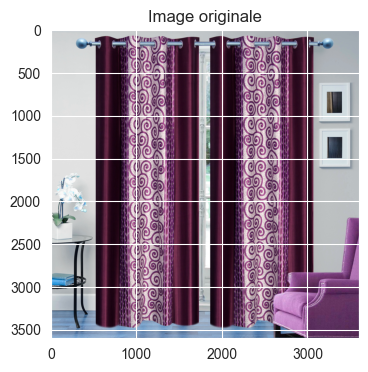

In [85]:
import cv2
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


# Chemin vers l'image prétraitée
image_path = '/Users/danongohou/Desktop/P6_Bis/Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg'

# Charger l'image prétraitée avec OpenCV
img = cv2.imread(image_path, cv2.COLOR_BGR2RGB)



# Charger l'image
#image_path = '/Users/danongohou/Desktop/P6/Images/'
#img = cv2.imread(image_path + image_df['image'][0])


plt.figure(figsize=(15, 4))
sns.set_style('darkgrid')

# Afficher l'image
plt.subplot(1, 3, 1)
plt.imshow(img) #cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Image originale')


### Image prétraitée et Histogramme des pixels

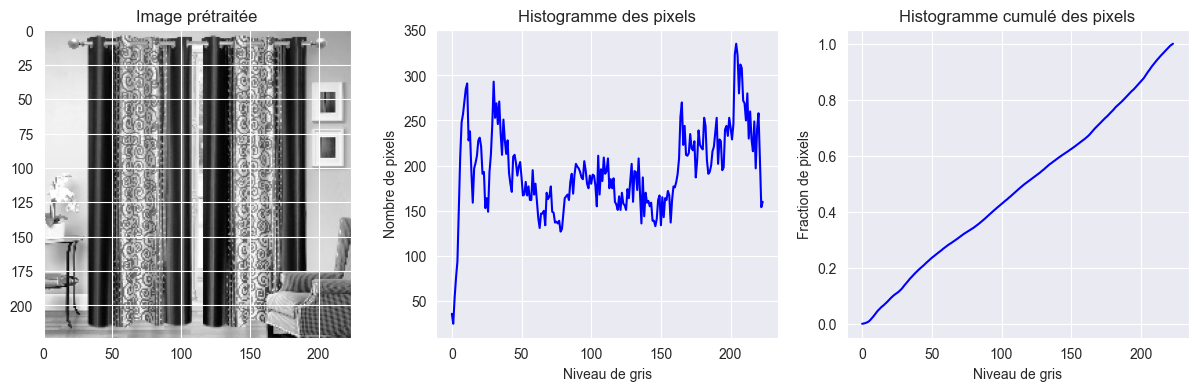

In [86]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Chemin vers l'image prétraitée
processed_image_path = '/Users/danongohou/Desktop/P6_Bis/Processed_Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg'

# Charger l'image prétraitée avec OpenCV
processed_image = cv2.imread(processed_image_path, cv2.IMREAD_GRAYSCALE)


plt.figure(figsize=(15, 4))
sns.set_style('darkgrid')

# Afficher l'image
plt.subplot(1, 3, 1)
plt.imshow(processed_image, cmap='gray')
plt.title('Image prétraitée')



# Calculer l'histogramme des pixels
histogram = cv2.calcHist([processed_image], [0], None, [224], [0, 224])

# Afficher l'histogramme des pixels
plt.subplot(1, 3, 2)
plt.plot(histogram, color='blue')
plt.xlabel('Niveau de gris')
plt.ylabel('Nombre de pixels')
plt.title('Histogramme des pixels')


# Calculer l'histogramme cumulé des pixels
cumulative_hist = np.cumsum(histogram)
# Normaliser l'histogramme cumulé pour le mettre à l'échelle de [0, 1]
cumulative_hist_norm = cumulative_hist / np.sum(histogram)

# Afficher l'histogramme cumulé des pixels
plt.subplot(1, 3, 3)
plt.plot(cumulative_hist_norm, color='blue')
plt.xlabel('Niveau de gris')
plt.ylabel('Fraction de pixels')
plt.title('Histogramme cumulé des pixels')

# Afficher les trois graphes côte à côte
plt.subplots_adjust(wspace=0.2)
plt.show()



# ORB

In [87]:
import pandas as pd 

data_image = pd.read_csv('image_data.csv')
data_image.info() 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1050 non-null   int64 
 1   image       1050 non-null   object
 2   image_loc   1050 non-null   object
 3   categorie   1050 non-null   object
dtypes: int64(1), object(3)
memory usage: 32.9+ KB


In [88]:
data_image.drop(columns=['Unnamed: 0', 'image_loc'], inplace=True)


In [89]:
 data_image.head()

,image,categorie
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,home furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,baby care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,baby care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,home furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,home furnishing


In [90]:
image_path = '/Users/danongohou/Desktop/P6_Bis/Processed_Images/'
data_image['image_loc'] = [image_path + row for row in data_image['image']]

In [91]:
data_image.head()

,image,categorie,image_loc
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,home furnishing,/Users/danongohou/Desktop/P6_Bis/Processed_Ima...
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,baby care,/Users/danongohou/Desktop/P6_Bis/Processed_Ima...
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,baby care,/Users/danongohou/Desktop/P6_Bis/Processed_Ima...
3,d4684dcdc759dd9cdf41504698d737d8.jpg,home furnishing,/Users/danongohou/Desktop/P6_Bis/Processed_Ima...
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,home furnishing,/Users/danongohou/Desktop/P6_Bis/Processed_Ima...


In [92]:
data_image.to_csv('data_image.csv')

- ## Extraction des features

In [93]:
import os
import cv2
import pickle
import numpy as np
from sklearn.cluster import KMeans

# Charger les images
images = []
for filename in os.listdir('/Users/danongohou/Desktop/P6_Bis/Processed_Images/'):
    if filename.endswith('.jpg') or filename.endswith('.jpeg'):
        image = cv2.imread(os.path.join('/Users/danongohou/Desktop/P6_Bis/Processed_Images/', 
                                        filename), cv2.IMREAD_GRAYSCALE)
        images.append(image)

import os
import cv2
import pickle

# Extraire les descripteurs ORB
orb = cv2.ORB_create()
descripteurs = []
keypoints = []
for image in images:
    kp, des = orb.detectAndCompute(image, None)
    descripteurs.append(des)
    keypoints.append(kp)
orb_list_descripteurs = np.vstack(descripteurs)

print(f'{len(images)} images chargées')
print(f'{len(orb_list_descripteurs)} descripteurs extraits')

# Vérifie si le répertoire 'sauvegarde' existe, sinon le crée
if not os.path.exists('orb_files/'):
    os.makedirs('orb_files/')

# Ouvre un fichier binaire 'les_descripteurs/orb_list_descripteurs.pickle' en mode écriture binaire ('wb')
with open('orb_files/orb_list_descripteurs.pickle', 'wb') as f:
    # Sérialise l'objet Python 'orb_list_descripteurs' et l'écrit dans le fichier binaire ouvert
    pickle.dump(orb_list_descripteurs, f, pickle.HIGHEST_PROTOCOL)


1050 images chargées
394376 descripteurs extraits


- ## Création du dictionnaire de visual words

In [94]:
import numpy as np
import pickle
from sklearn.cluster import KMeans

# Charger les descripteurs ORB extraits dans la question précédente
with open('orb_files/orb_list_descripteurs.pickle', 'rb') as f:
    orb_list_descripteurs = pickle.load(f)

import numpy as np
import pickle
from sklearn.cluster import KMeans

# Appliquer la méthode k-means pour regrouper 
# les descripteurs en clusters
orb_kmeans = KMeans(n_clusters=1000, n_init=10, 
                    random_state=0)
orb_kmeans.fit(orb_list_descripteurs)
visual_words = orb_kmeans.cluster_centers_

# Sauvegarder le dictionnaire de visual words dans un fichier pickle
with open('orb_files/visual_words.pickle', 'wb') as f:
    pickle.dump(orb_kmeans.cluster_centers_, f)


# Sauvegarde du modèle KMeans entraîné dans un fichier
with open('orb_files/orb_kmeans.pickle', 'wb') as f:
    pickle.dump(orb_kmeans, f)


In [95]:
np.save('orb_files/orb_list_descripteurs.npy', orb_list_descripteurs)
np.save('orb_files/visual_words.npy', visual_words)
np.save('orb_files/orb_kmeans.npy', orb_kmeans)


- ## Histogramme

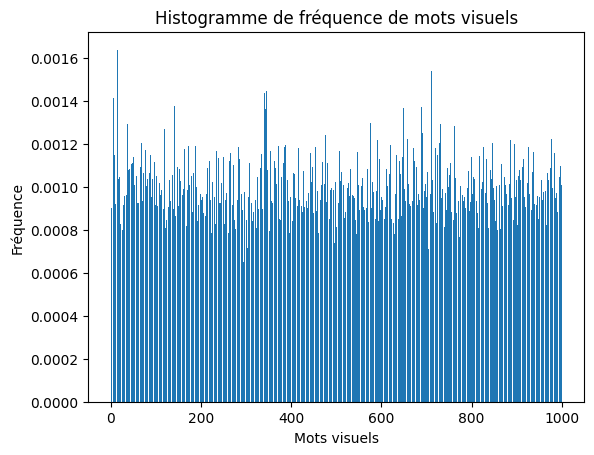

In [106]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Charger les descripteurs ORB extraits dans la question précédente
with open('orb_files/orb_list_descripteurs.pickle', 'rb') as f:
    orb_list_descripteurs = pickle.load(f)

# Charger le dictionnaire de mots visuels
with open('orb_files/visual_words.pickle', 'rb') as f:
    visual_words = pickle.load(f)
# Sauvegarde du modèle KMeans entraîné dans un fichier
with open('orb_files/orb_kmeans.pickle', 'rb') as f:
    orb_kmeans= pickle.load(f)


# Assigner chaque descripteur ORB à un mot visuel dans le dictionnaire
orb_descr_visual = orb_kmeans.predict(orb_list_descripteurs)

# Créer l'histogramme de fréquence de mots visuels
orb_hist, _ = np.histogram(orb_descr_visual, bins=len(visual_words), 
                           range=(0, len(visual_words)))
orb_hist = orb_hist.astype(float) / len(orb_list_descripteurs)

# Afficher l'histogramme
plt.bar(range(len(visual_words)), orb_hist)
plt.xlabel('Mots visuels')
plt.ylabel('Fréquence')
plt.title('Histogramme de fréquence de mots visuels')
plt.show()


### Dataframe de vecteurs des features issus de ORB

In [98]:
# Charger les descripteurs ORB extraits dans la question précédente
with open('orb_files/orb_list_descripteurs.pickle', 'rb') as f:
    orb_list_descripteurs = pickle.load(f)
    
# Dataframe de vecteurs des features issus de ResNet152
df_features_vectors = pd.DataFrame.from_records(orb_list_descripteurs)

# Sauvegarde du dataframe des vectors BOVW ResNet152
with open('orb_files/df_features_vectors.pickle', 'wb') as f:
    pickle.dump(df_features_vectors, f, pickle.HIGHEST_PROTOCOL)


In [99]:
orb_list_descripteurs.shape

(394376, 32)

### PCA

In [1]:
import pandas as pd 
# Charger les données de data_image.csv
df = pd.read_csv('data_image.csv')
df.head()

,Unnamed: 0,image,categorie,image_loc
0,0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,home furnishing,/Users/danongohou/Desktop/P6_Bis/Processed_Ima...
1,1,7b72c92c2f6c40268628ec5f14c6d590.jpg,baby care,/Users/danongohou/Desktop/P6_Bis/Processed_Ima...
2,2,64d5d4a258243731dc7bbb1eef49ad74.jpg,baby care,/Users/danongohou/Desktop/P6_Bis/Processed_Ima...
3,3,d4684dcdc759dd9cdf41504698d737d8.jpg,home furnishing,/Users/danongohou/Desktop/P6_Bis/Processed_Ima...
4,4,6325b6870c54cd47be6ebfbffa620ec7.jpg,home furnishing,/Users/danongohou/Desktop/P6_Bis/Processed_Ima...


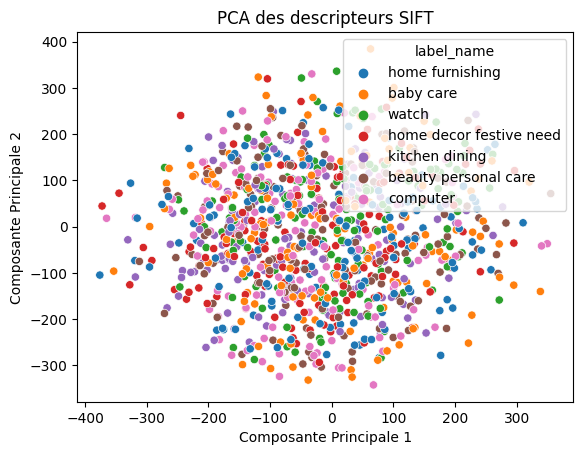

(394376, 32)
(394376, 18)


In [2]:
import pandas as pd
import cv2
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pickle

# Charger les données de data_image.csv
df = pd.read_csv('data_image.csv')

# Charger les descripteurs ORB extraits dans la question précédente
with open('orb_files/df_features_vectors.pickle', 'rb') as f:
    df_features_vectors = pickle.load(f)

# Appliquer une réduction de dimensionnalité avec PCA
pca = PCA(n_components=0.80)
descripteurs_pca = pca.fit_transform(df_features_vectors)

# Créer un dataframe pour les données du PCA
descriptors_pca_df = descripteurs_pca[:, [0, 1]]
descriptors_pca_df = pd.DataFrame(descriptors_pca_df, columns=["pc1", "pc2"])
descriptors_pca_df["label_name"] = df["categorie"]


# Afficher le graphique avec labels de catégorie
sns.scatterplot(data=descriptors_pca_df, x="pc1", y="pc2", hue="label_name")
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.title('PCA des descripteurs SIFT')
plt.show()


print(df_features_vectors.shape) 
print(descripteurs_pca.shape)

### Choix hyperparametres pour T-SNE

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns


# Charger les descripteurs ORB extraits dans la question précédente
with open('orb_files/df_features_vectors.pickle', 'rb') as f:
    df_features_vectors = pickle.load(f)

    
liste_param = [20, 30, 40, 50, 70, 80]
results_resnet = list()
tsne_results = []
for i in liste_param:
    tsne = TSNE(n_components=2, verbose=1, perplexity=i, n_iter=500,random_state=42)
    tsne_results = tsne.fit_transform(descripteurs_pca)
    results_resnet.append(tsne_results)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 394376 samples in 0.053s...
[t-SNE] Computed neighbors for 394376 samples in 265.443s...
[t-SNE] Computed conditional probabilities for sample 1000 / 394376
[t-SNE] Computed conditional probabilities for sample 2000 / 394376
[t-SNE] Computed conditional probabilities for sample 3000 / 394376
[t-SNE] Computed conditional probabilities for sample 4000 / 394376
[t-SNE] Computed conditional probabilities for sample 5000 / 394376
[t-SNE] Computed conditional probabilities for sample 6000 / 394376
[t-SNE] Computed conditional probabilities for sample 7000 / 394376
[t-SNE] Computed conditional probabilities for sample 8000 / 394376
[t-SNE] Computed conditional probabilities for sample 9000 / 394376
[t-SNE] Computed conditional probabilities for sample 10000 / 394376
[t-SNE] Computed conditional probabilities for sample 11000 / 394376
[t-SNE] Computed conditional probabilities for sample 12000 / 394376
[t-SNE] Computed conditional proba

[t-SNE] Computed conditional probabilities for sample 132000 / 394376
[t-SNE] Computed conditional probabilities for sample 133000 / 394376
[t-SNE] Computed conditional probabilities for sample 134000 / 394376
[t-SNE] Computed conditional probabilities for sample 135000 / 394376
[t-SNE] Computed conditional probabilities for sample 136000 / 394376
[t-SNE] Computed conditional probabilities for sample 137000 / 394376
[t-SNE] Computed conditional probabilities for sample 138000 / 394376
[t-SNE] Computed conditional probabilities for sample 139000 / 394376
[t-SNE] Computed conditional probabilities for sample 140000 / 394376
[t-SNE] Computed conditional probabilities for sample 141000 / 394376
[t-SNE] Computed conditional probabilities for sample 142000 / 394376
[t-SNE] Computed conditional probabilities for sample 143000 / 394376
[t-SNE] Computed conditional probabilities for sample 144000 / 394376
[t-SNE] Computed conditional probabilities for sample 145000 / 394376
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 253000 / 394376
[t-SNE] Computed conditional probabilities for sample 254000 / 394376
[t-SNE] Computed conditional probabilities for sample 255000 / 394376
[t-SNE] Computed conditional probabilities for sample 256000 / 394376
[t-SNE] Computed conditional probabilities for sample 257000 / 394376
[t-SNE] Computed conditional probabilities for sample 258000 / 394376
[t-SNE] Computed conditional probabilities for sample 259000 / 394376
[t-SNE] Computed conditional probabilities for sample 260000 / 394376
[t-SNE] Computed conditional probabilities for sample 261000 / 394376
[t-SNE] Computed conditional probabilities for sample 262000 / 394376
[t-SNE] Computed conditional probabilities for sample 263000 / 394376
[t-SNE] Computed conditional probabilities for sample 264000 / 394376
[t-SNE] Computed conditional probabilities for sample 265000 / 394376
[t-SNE] Computed conditional probabilities for sample 266000 / 394376
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 379000 / 394376
[t-SNE] Computed conditional probabilities for sample 380000 / 394376
[t-SNE] Computed conditional probabilities for sample 381000 / 394376
[t-SNE] Computed conditional probabilities for sample 382000 / 394376
[t-SNE] Computed conditional probabilities for sample 383000 / 394376
[t-SNE] Computed conditional probabilities for sample 384000 / 394376
[t-SNE] Computed conditional probabilities for sample 385000 / 394376
[t-SNE] Computed conditional probabilities for sample 386000 / 394376
[t-SNE] Computed conditional probabilities for sample 387000 / 394376
[t-SNE] Computed conditional probabilities for sample 388000 / 394376
[t-SNE] Computed conditional probabilities for sample 389000 / 394376
[t-SNE] Computed conditional probabilities for sample 390000 / 394376
[t-SNE] Computed conditional probabilities for sample 391000 / 394376
[t-SNE] Computed conditional probabilities for sample 392000 / 394376
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 101000 / 394376
[t-SNE] Computed conditional probabilities for sample 102000 / 394376
[t-SNE] Computed conditional probabilities for sample 103000 / 394376
[t-SNE] Computed conditional probabilities for sample 104000 / 394376
[t-SNE] Computed conditional probabilities for sample 105000 / 394376
[t-SNE] Computed conditional probabilities for sample 106000 / 394376
[t-SNE] Computed conditional probabilities for sample 107000 / 394376
[t-SNE] Computed conditional probabilities for sample 108000 / 394376
[t-SNE] Computed conditional probabilities for sample 109000 / 394376
[t-SNE] Computed conditional probabilities for sample 110000 / 394376
[t-SNE] Computed conditional probabilities for sample 111000 / 394376
[t-SNE] Computed conditional probabilities for sample 112000 / 394376
[t-SNE] Computed conditional probabilities for sample 113000 / 394376
[t-SNE] Computed conditional probabilities for sample 114000 / 394376
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 223000 / 394376
[t-SNE] Computed conditional probabilities for sample 224000 / 394376
[t-SNE] Computed conditional probabilities for sample 225000 / 394376
[t-SNE] Computed conditional probabilities for sample 226000 / 394376
[t-SNE] Computed conditional probabilities for sample 227000 / 394376
[t-SNE] Computed conditional probabilities for sample 228000 / 394376
[t-SNE] Computed conditional probabilities for sample 229000 / 394376
[t-SNE] Computed conditional probabilities for sample 230000 / 394376
[t-SNE] Computed conditional probabilities for sample 231000 / 394376
[t-SNE] Computed conditional probabilities for sample 232000 / 394376
[t-SNE] Computed conditional probabilities for sample 233000 / 394376
[t-SNE] Computed conditional probabilities for sample 234000 / 394376
[t-SNE] Computed conditional probabilities for sample 235000 / 394376
[t-SNE] Computed conditional probabilities for sample 236000 / 394376
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 342000 / 394376
[t-SNE] Computed conditional probabilities for sample 343000 / 394376
[t-SNE] Computed conditional probabilities for sample 344000 / 394376
[t-SNE] Computed conditional probabilities for sample 345000 / 394376
[t-SNE] Computed conditional probabilities for sample 346000 / 394376
[t-SNE] Computed conditional probabilities for sample 347000 / 394376
[t-SNE] Computed conditional probabilities for sample 348000 / 394376
[t-SNE] Computed conditional probabilities for sample 349000 / 394376
[t-SNE] Computed conditional probabilities for sample 350000 / 394376
[t-SNE] Computed conditional probabilities for sample 351000 / 394376
[t-SNE] Computed conditional probabilities for sample 352000 / 394376
[t-SNE] Computed conditional probabilities for sample 353000 / 394376
[t-SNE] Computed conditional probabilities for sample 354000 / 394376
[t-SNE] Computed conditional probabilities for sample 355000 / 394376
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 63000 / 394376
[t-SNE] Computed conditional probabilities for sample 64000 / 394376
[t-SNE] Computed conditional probabilities for sample 65000 / 394376
[t-SNE] Computed conditional probabilities for sample 66000 / 394376
[t-SNE] Computed conditional probabilities for sample 67000 / 394376
[t-SNE] Computed conditional probabilities for sample 68000 / 394376
[t-SNE] Computed conditional probabilities for sample 69000 / 394376
[t-SNE] Computed conditional probabilities for sample 70000 / 394376
[t-SNE] Computed conditional probabilities for sample 71000 / 394376
[t-SNE] Computed conditional probabilities for sample 72000 / 394376
[t-SNE] Computed conditional probabilities for sample 73000 / 394376
[t-SNE] Computed conditional probabilities for sample 74000 / 394376
[t-SNE] Computed conditional probabilities for sample 75000 / 394376
[t-SNE] Computed conditional probabilities for sample 76000 / 394376
[t-SNE] Computed conditional proba

[t-SNE] Computed conditional probabilities for sample 189000 / 394376
[t-SNE] Computed conditional probabilities for sample 190000 / 394376
[t-SNE] Computed conditional probabilities for sample 191000 / 394376
[t-SNE] Computed conditional probabilities for sample 192000 / 394376
[t-SNE] Computed conditional probabilities for sample 193000 / 394376
[t-SNE] Computed conditional probabilities for sample 194000 / 394376
[t-SNE] Computed conditional probabilities for sample 195000 / 394376
[t-SNE] Computed conditional probabilities for sample 196000 / 394376
[t-SNE] Computed conditional probabilities for sample 197000 / 394376
[t-SNE] Computed conditional probabilities for sample 198000 / 394376
[t-SNE] Computed conditional probabilities for sample 199000 / 394376
[t-SNE] Computed conditional probabilities for sample 200000 / 394376
[t-SNE] Computed conditional probabilities for sample 201000 / 394376
[t-SNE] Computed conditional probabilities for sample 202000 / 394376
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 315000 / 394376
[t-SNE] Computed conditional probabilities for sample 316000 / 394376
[t-SNE] Computed conditional probabilities for sample 317000 / 394376
[t-SNE] Computed conditional probabilities for sample 318000 / 394376
[t-SNE] Computed conditional probabilities for sample 319000 / 394376
[t-SNE] Computed conditional probabilities for sample 320000 / 394376
[t-SNE] Computed conditional probabilities for sample 321000 / 394376
[t-SNE] Computed conditional probabilities for sample 322000 / 394376
[t-SNE] Computed conditional probabilities for sample 323000 / 394376
[t-SNE] Computed conditional probabilities for sample 324000 / 394376
[t-SNE] Computed conditional probabilities for sample 325000 / 394376
[t-SNE] Computed conditional probabilities for sample 326000 / 394376
[t-SNE] Computed conditional probabilities for sample 327000 / 394376
[t-SNE] Computed conditional probabilities for sample 328000 / 394376
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 37000 / 394376
[t-SNE] Computed conditional probabilities for sample 38000 / 394376
[t-SNE] Computed conditional probabilities for sample 39000 / 394376
[t-SNE] Computed conditional probabilities for sample 40000 / 394376
[t-SNE] Computed conditional probabilities for sample 41000 / 394376
[t-SNE] Computed conditional probabilities for sample 42000 / 394376
[t-SNE] Computed conditional probabilities for sample 43000 / 394376
[t-SNE] Computed conditional probabilities for sample 44000 / 394376
[t-SNE] Computed conditional probabilities for sample 45000 / 394376
[t-SNE] Computed conditional probabilities for sample 46000 / 394376
[t-SNE] Computed conditional probabilities for sample 47000 / 394376
[t-SNE] Computed conditional probabilities for sample 48000 / 394376
[t-SNE] Computed conditional probabilities for sample 49000 / 394376
[t-SNE] Computed conditional probabilities for sample 50000 / 394376
[t-SNE] Computed conditional proba

[t-SNE] Computed conditional probabilities for sample 161000 / 394376
[t-SNE] Computed conditional probabilities for sample 162000 / 394376
[t-SNE] Computed conditional probabilities for sample 163000 / 394376
[t-SNE] Computed conditional probabilities for sample 164000 / 394376
[t-SNE] Computed conditional probabilities for sample 165000 / 394376
[t-SNE] Computed conditional probabilities for sample 166000 / 394376
[t-SNE] Computed conditional probabilities for sample 167000 / 394376
[t-SNE] Computed conditional probabilities for sample 168000 / 394376
[t-SNE] Computed conditional probabilities for sample 169000 / 394376
[t-SNE] Computed conditional probabilities for sample 170000 / 394376
[t-SNE] Computed conditional probabilities for sample 171000 / 394376
[t-SNE] Computed conditional probabilities for sample 172000 / 394376
[t-SNE] Computed conditional probabilities for sample 173000 / 394376
[t-SNE] Computed conditional probabilities for sample 174000 / 394376
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 281000 / 394376
[t-SNE] Computed conditional probabilities for sample 282000 / 394376
[t-SNE] Computed conditional probabilities for sample 283000 / 394376
[t-SNE] Computed conditional probabilities for sample 284000 / 394376
[t-SNE] Computed conditional probabilities for sample 285000 / 394376
[t-SNE] Computed conditional probabilities for sample 286000 / 394376
[t-SNE] Computed conditional probabilities for sample 287000 / 394376
[t-SNE] Computed conditional probabilities for sample 288000 / 394376
[t-SNE] Computed conditional probabilities for sample 289000 / 394376
[t-SNE] Computed conditional probabilities for sample 290000 / 394376
[t-SNE] Computed conditional probabilities for sample 291000 / 394376
[t-SNE] Computed conditional probabilities for sample 292000 / 394376
[t-SNE] Computed conditional probabilities for sample 293000 / 394376
[t-SNE] Computed conditional probabilities for sample 294000 / 394376
[t-SNE] Computed con

[t-SNE] Indexed 394376 samples in 0.054s...
[t-SNE] Computed neighbors for 394376 samples in 300.302s...
[t-SNE] Computed conditional probabilities for sample 1000 / 394376
[t-SNE] Computed conditional probabilities for sample 2000 / 394376
[t-SNE] Computed conditional probabilities for sample 3000 / 394376
[t-SNE] Computed conditional probabilities for sample 4000 / 394376
[t-SNE] Computed conditional probabilities for sample 5000 / 394376
[t-SNE] Computed conditional probabilities for sample 6000 / 394376
[t-SNE] Computed conditional probabilities for sample 7000 / 394376
[t-SNE] Computed conditional probabilities for sample 8000 / 394376
[t-SNE] Computed conditional probabilities for sample 9000 / 394376
[t-SNE] Computed conditional probabilities for sample 10000 / 394376
[t-SNE] Computed conditional probabilities for sample 11000 / 394376
[t-SNE] Computed conditional probabilities for sample 12000 / 394376
[t-SNE] Computed conditional probabilities for sample 13000 / 394376
[t-SNE]

[t-SNE] Computed conditional probabilities for sample 127000 / 394376
[t-SNE] Computed conditional probabilities for sample 128000 / 394376
[t-SNE] Computed conditional probabilities for sample 129000 / 394376
[t-SNE] Computed conditional probabilities for sample 130000 / 394376
[t-SNE] Computed conditional probabilities for sample 131000 / 394376
[t-SNE] Computed conditional probabilities for sample 132000 / 394376
[t-SNE] Computed conditional probabilities for sample 133000 / 394376
[t-SNE] Computed conditional probabilities for sample 134000 / 394376
[t-SNE] Computed conditional probabilities for sample 135000 / 394376
[t-SNE] Computed conditional probabilities for sample 136000 / 394376
[t-SNE] Computed conditional probabilities for sample 137000 / 394376
[t-SNE] Computed conditional probabilities for sample 138000 / 394376
[t-SNE] Computed conditional probabilities for sample 139000 / 394376
[t-SNE] Computed conditional probabilities for sample 140000 / 394376
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 245000 / 394376
[t-SNE] Computed conditional probabilities for sample 246000 / 394376
[t-SNE] Computed conditional probabilities for sample 247000 / 394376
[t-SNE] Computed conditional probabilities for sample 248000 / 394376
[t-SNE] Computed conditional probabilities for sample 249000 / 394376
[t-SNE] Computed conditional probabilities for sample 250000 / 394376
[t-SNE] Computed conditional probabilities for sample 251000 / 394376
[t-SNE] Computed conditional probabilities for sample 252000 / 394376
[t-SNE] Computed conditional probabilities for sample 253000 / 394376
[t-SNE] Computed conditional probabilities for sample 254000 / 394376
[t-SNE] Computed conditional probabilities for sample 255000 / 394376
[t-SNE] Computed conditional probabilities for sample 256000 / 394376
[t-SNE] Computed conditional probabilities for sample 257000 / 394376
[t-SNE] Computed conditional probabilities for sample 258000 / 394376
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 371000 / 394376
[t-SNE] Computed conditional probabilities for sample 372000 / 394376
[t-SNE] Computed conditional probabilities for sample 373000 / 394376
[t-SNE] Computed conditional probabilities for sample 374000 / 394376
[t-SNE] Computed conditional probabilities for sample 375000 / 394376
[t-SNE] Computed conditional probabilities for sample 376000 / 394376
[t-SNE] Computed conditional probabilities for sample 377000 / 394376
[t-SNE] Computed conditional probabilities for sample 378000 / 394376
[t-SNE] Computed conditional probabilities for sample 379000 / 394376
[t-SNE] Computed conditional probabilities for sample 380000 / 394376
[t-SNE] Computed conditional probabilities for sample 381000 / 394376
[t-SNE] Computed conditional probabilities for sample 382000 / 394376
[t-SNE] Computed conditional probabilities for sample 383000 / 394376
[t-SNE] Computed conditional probabilities for sample 384000 / 394376
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 94000 / 394376
[t-SNE] Computed conditional probabilities for sample 95000 / 394376
[t-SNE] Computed conditional probabilities for sample 96000 / 394376
[t-SNE] Computed conditional probabilities for sample 97000 / 394376
[t-SNE] Computed conditional probabilities for sample 98000 / 394376
[t-SNE] Computed conditional probabilities for sample 99000 / 394376
[t-SNE] Computed conditional probabilities for sample 100000 / 394376
[t-SNE] Computed conditional probabilities for sample 101000 / 394376
[t-SNE] Computed conditional probabilities for sample 102000 / 394376
[t-SNE] Computed conditional probabilities for sample 103000 / 394376
[t-SNE] Computed conditional probabilities for sample 104000 / 394376
[t-SNE] Computed conditional probabilities for sample 105000 / 394376
[t-SNE] Computed conditional probabilities for sample 106000 / 394376
[t-SNE] Computed conditional probabilities for sample 107000 / 394376
[t-SNE] Computed condition

[t-SNE] Computed conditional probabilities for sample 214000 / 394376
[t-SNE] Computed conditional probabilities for sample 215000 / 394376
[t-SNE] Computed conditional probabilities for sample 216000 / 394376
[t-SNE] Computed conditional probabilities for sample 217000 / 394376
[t-SNE] Computed conditional probabilities for sample 218000 / 394376
[t-SNE] Computed conditional probabilities for sample 219000 / 394376
[t-SNE] Computed conditional probabilities for sample 220000 / 394376
[t-SNE] Computed conditional probabilities for sample 221000 / 394376
[t-SNE] Computed conditional probabilities for sample 222000 / 394376
[t-SNE] Computed conditional probabilities for sample 223000 / 394376
[t-SNE] Computed conditional probabilities for sample 224000 / 394376
[t-SNE] Computed conditional probabilities for sample 225000 / 394376
[t-SNE] Computed conditional probabilities for sample 226000 / 394376
[t-SNE] Computed conditional probabilities for sample 227000 / 394376
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 338000 / 394376
[t-SNE] Computed conditional probabilities for sample 339000 / 394376
[t-SNE] Computed conditional probabilities for sample 340000 / 394376
[t-SNE] Computed conditional probabilities for sample 341000 / 394376
[t-SNE] Computed conditional probabilities for sample 342000 / 394376
[t-SNE] Computed conditional probabilities for sample 343000 / 394376
[t-SNE] Computed conditional probabilities for sample 344000 / 394376
[t-SNE] Computed conditional probabilities for sample 345000 / 394376
[t-SNE] Computed conditional probabilities for sample 346000 / 394376
[t-SNE] Computed conditional probabilities for sample 347000 / 394376
[t-SNE] Computed conditional probabilities for sample 348000 / 394376
[t-SNE] Computed conditional probabilities for sample 349000 / 394376
[t-SNE] Computed conditional probabilities for sample 350000 / 394376
[t-SNE] Computed conditional probabilities for sample 351000 / 394376
[t-SNE] Computed con

### T-SNE

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Charger les descripteurs ORB extraits dans la question précédente
with open('orb_files/df_features_vectors.pickle', 'rb') as f:
    df_features_vectors = pickle.load(f)

# Charger les données de data_image.csv
df = pd.read_csv('data_image.csv')

# Réduction de dimension tsne
tsne = TSNE(n_components=2, verbose=1, perplexity=80, n_iter=500)
orb_tsne = tsne.fit_transform(descripteurs_pca)


[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 394376 samples in 0.049s...
[t-SNE] Computed neighbors for 394376 samples in 231.405s...
[t-SNE] Computed conditional probabilities for sample 1000 / 394376
[t-SNE] Computed conditional probabilities for sample 2000 / 394376
[t-SNE] Computed conditional probabilities for sample 3000 / 394376
[t-SNE] Computed conditional probabilities for sample 4000 / 394376
[t-SNE] Computed conditional probabilities for sample 5000 / 394376
[t-SNE] Computed conditional probabilities for sample 6000 / 394376
[t-SNE] Computed conditional probabilities for sample 7000 / 394376
[t-SNE] Computed conditional probabilities for sample 8000 / 394376
[t-SNE] Computed conditional probabilities for sample 9000 / 394376
[t-SNE] Computed conditional probabilities for sample 10000 / 394376
[t-SNE] Computed conditional probabilities for sample 11000 / 394376
[t-SNE] Computed conditional probabilities for sample 12000 / 394376
[t-SNE] Computed conditional prob

[t-SNE] Computed conditional probabilities for sample 124000 / 394376
[t-SNE] Computed conditional probabilities for sample 125000 / 394376
[t-SNE] Computed conditional probabilities for sample 126000 / 394376
[t-SNE] Computed conditional probabilities for sample 127000 / 394376
[t-SNE] Computed conditional probabilities for sample 128000 / 394376
[t-SNE] Computed conditional probabilities for sample 129000 / 394376
[t-SNE] Computed conditional probabilities for sample 130000 / 394376
[t-SNE] Computed conditional probabilities for sample 131000 / 394376
[t-SNE] Computed conditional probabilities for sample 132000 / 394376
[t-SNE] Computed conditional probabilities for sample 133000 / 394376
[t-SNE] Computed conditional probabilities for sample 134000 / 394376
[t-SNE] Computed conditional probabilities for sample 135000 / 394376
[t-SNE] Computed conditional probabilities for sample 136000 / 394376
[t-SNE] Computed conditional probabilities for sample 137000 / 394376
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 246000 / 394376
[t-SNE] Computed conditional probabilities for sample 247000 / 394376
[t-SNE] Computed conditional probabilities for sample 248000 / 394376
[t-SNE] Computed conditional probabilities for sample 249000 / 394376
[t-SNE] Computed conditional probabilities for sample 250000 / 394376
[t-SNE] Computed conditional probabilities for sample 251000 / 394376
[t-SNE] Computed conditional probabilities for sample 252000 / 394376
[t-SNE] Computed conditional probabilities for sample 253000 / 394376
[t-SNE] Computed conditional probabilities for sample 254000 / 394376
[t-SNE] Computed conditional probabilities for sample 255000 / 394376
[t-SNE] Computed conditional probabilities for sample 256000 / 394376
[t-SNE] Computed conditional probabilities for sample 257000 / 394376
[t-SNE] Computed conditional probabilities for sample 258000 / 394376
[t-SNE] Computed conditional probabilities for sample 259000 / 394376
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 372000 / 394376
[t-SNE] Computed conditional probabilities for sample 373000 / 394376
[t-SNE] Computed conditional probabilities for sample 374000 / 394376
[t-SNE] Computed conditional probabilities for sample 375000 / 394376
[t-SNE] Computed conditional probabilities for sample 376000 / 394376
[t-SNE] Computed conditional probabilities for sample 377000 / 394376
[t-SNE] Computed conditional probabilities for sample 378000 / 394376
[t-SNE] Computed conditional probabilities for sample 379000 / 394376
[t-SNE] Computed conditional probabilities for sample 380000 / 394376
[t-SNE] Computed conditional probabilities for sample 381000 / 394376
[t-SNE] Computed conditional probabilities for sample 382000 / 394376
[t-SNE] Computed conditional probabilities for sample 383000 / 394376
[t-SNE] Computed conditional probabilities for sample 384000 / 394376
[t-SNE] Computed conditional probabilities for sample 385000 / 394376
[t-SNE] Computed con

In [4]:
import pickle
# Sauvegarde du dataframe des vectors BOVW ResNet152
with open('orb_files/orb_tsne.pickle', 'wb') as f:
    pickle.dump(orb_tsne, f, pickle.HIGHEST_PROTOCOL)
    

### DataFrame TSNE

In [5]:
import pandas as pd 
from sklearn.preprocessing import LabelEncoder

# Charger les descripteurs ORB extraits dans la question précédente
with open('orb_files/orb_tsne.pickle', 'rb') as f:
    orb_tsne = pickle.load(f)
    
# Charger les données de data_image.csv
df = pd.read_csv('data_image.csv')

tsne_df  = pd.DataFrame(orb_tsne, columns=['tsne1', 'tsne2'])

# Fusionner les DataFrames
tsne_df = tsne_df.merge(df[["categorie", "image", "image_loc"]], 
                                                left_index=True, right_index=True)


enc = LabelEncoder()
tsne_df["label"] = enc.fit_transform(tsne_df["categorie"])
labels_true = tsne_df["label"]

import pickle
# Sauvegarde du dataframe des vectors BOVW ResNet152
with open('orb_files/tsne_df.pickle', 'wb') as f:
    pickle.dump(tsne_df, f, pickle.HIGHEST_PROTOCOL)

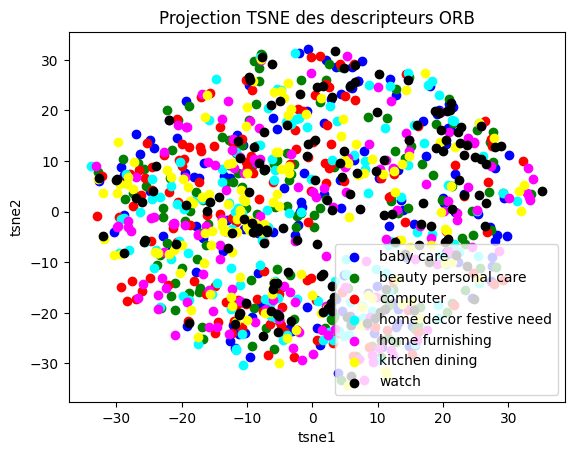

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Charger les données de data_image.csv
df = pd.read_csv('data_image.csv')

# Ajouter la colonne color_labels au dataframe df
color_labels = df['categorie']
df['categorie'] = color_labels

# Tracer le nuage de points avec 7 couleurs différentes
fig, ax = plt.subplots()
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
for i, label in enumerate(np.unique(color_labels)):
    idx = np.where(color_labels == label)
    ax.scatter(orb_tsne[idx, 0], orb_tsne[idx, 1], c=colors[i], label=label)
ax.legend()
plt.title("Projection TSNE des descripteurs ORB")
plt.xlabel("tsne1")
plt.ylabel("tsne2")
plt.show()

### KMEANS

In [113]:
import pickle

# Charger les descripteurs ORB extraits dans la question précédente
with open('orb_files/tsne_df.pickle', 'rb') as f:
    tsne_df = pickle.load(f)

In [114]:
tsne_df.head() 

,tsne1,tsne2,categorie,image,image_loc,label
0,-11.124104,-17.627275,home furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg,/Users/danongohou/Desktop/P6_Bis/Processed_Ima...,4
1,-8.274206,-4.257312,baby care,7b72c92c2f6c40268628ec5f14c6d590.jpg,/Users/danongohou/Desktop/P6_Bis/Processed_Ima...,0
2,-13.058793,-1.669282,baby care,64d5d4a258243731dc7bbb1eef49ad74.jpg,/Users/danongohou/Desktop/P6_Bis/Processed_Ima...,0
3,16.501244,-2.867632,home furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg,/Users/danongohou/Desktop/P6_Bis/Processed_Ima...,4
4,-14.204253,-9.415519,home furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg,/Users/danongohou/Desktop/P6_Bis/Processed_Ima...,4


In [115]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import cluster, metrics
from sklearn.cluster import KMeans

tsne_df_copy = tsne_df.copy()

# Instanciation du modèle KMeans avec les meilleurs paramètres
cols = ['tsne1', 'tsne2']

kmeans_tsne = KMeans(n_clusters=7, init='k-means++', 
                     n_init=10, max_iter=200, random_state=42).fit(tsne_df_copy[cols])

# Ajout de l'assignation du cluster au dataframe
tsne_df_copy['kmeans_labels'] = kmeans_tsne.labels_

tsne_df_copy.head()

,tsne1,tsne2,categorie,image,image_loc,label,kmeans_labels
0,-11.124104,-17.627275,home furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg,/Users/danongohou/Desktop/P6_Bis/Processed_Ima...,4,2
1,-8.274206,-4.257312,baby care,7b72c92c2f6c40268628ec5f14c6d590.jpg,/Users/danongohou/Desktop/P6_Bis/Processed_Ima...,0,1
2,-13.058793,-1.669282,baby care,64d5d4a258243731dc7bbb1eef49ad74.jpg,/Users/danongohou/Desktop/P6_Bis/Processed_Ima...,0,1
3,16.501244,-2.867632,home furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg,/Users/danongohou/Desktop/P6_Bis/Processed_Ima...,4,0
4,-14.204253,-9.415519,home furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg,/Users/danongohou/Desktop/P6_Bis/Processed_Ima...,4,2


### Fonction de mapping entre clusters obetenus avec les vraies catégories

In [154]:
# Function to map predicted labels to true category names
def get_named_labels_and_num_to_name(pred_labels, true_categ_names_list):
    label_num_to_name = {} # Créer un dictionnaire vide pour stocker les noms de catégorie réelle correspondants aux labels prédits

    for pred_label in sorted(set(pred_labels)): # Boucle pour chaque label prédit unique dans la liste de labels prédits
        # Extraction des indices des éléments correspondants à ce label dans la liste "pred_labels"
        indices = [i for i in range(len(pred_labels)) if pred_labels[i] == pred_label] 

        # Extraction des noms de catégories réelles correspondants aux indices dans la liste "true_categ_names_list"
        categ_names = [true_categ_names_list[i] for i in indices] 

        # Création d'une série Pandas avec les noms de catégories réelles extraits, 
        # puis utilisation de la méthode "value_counts()" pour obtenir le nombre d'occurrences de chaque nom de catégorie réelle
        categ_name_counts = pd.Series(categ_names).value_counts() 

        # Utilisation de la méthode "idxmax()" pour obtenir le nom de catégorie réelle le plus fréquent dans la série
        most_common_categ_name = categ_name_counts.idxmax() 

        # Stockage du label prédit et du nom de catégorie réelle correspondant dans le dictionnaire "label_num_to_name"
        label_num_to_name[pred_label] = most_common_categ_name

        # Remplacement de chaque occurrence du label prédit par le nom de catégorie réelle correspondant dans la liste "pred_labels"
        pred_labels = [x if x != pred_label else most_common_categ_name for x in pred_labels]

    return label_num_to_name # Renvoi du dictionnaire "label_num_to_name" qui mappe les labels prédits aux noms de catégories réelles correspondantes


categ_names = tsne_df_copy["categorie"]
predicted_labels = tsne_df_copy['kmeans_labels']

label_num_to_name = get_named_labels_and_num_to_name(predicted_labels, categ_names)
label_num_to_name


{0: 'baby care',
 1: 'kitchen dining',
 2: 'computer',
 3: 'baby care',
 4: 'watch',
 5: 'home furnishing',
 6: 'computer'}

In [144]:
tsne_df_copy['categorie'].unique()

array(['home furnishing', 'baby care', 'watch', 'home decor festive need',
       'kitchen dining', 'beauty personal care', 'computer'], dtype=object)

In [155]:
df = {'baby care': '0',
      'kitchen dining': '1', 
      'computer': '2', 
      'baby care': '3', 
      'watch': '4', 
      'home furnishing': '5',
      'computer': '6'}


tsne_df_copy['true_labels'] = tsne_df_copy['categorie'].map(df)

In [158]:
tsne_df_copy['true_labels'].fillna('', inplace=True)


In [159]:
tsne_df_copy.sample(20)

,tsne1,tsne2,categorie,image,image_loc,label,kmeans_labels,true_labels
534,-11.847915,-22.128973,watch,4019ad332ca3ce22449ff54fdd49a273.jpg,/Users/danongohou/Desktop/P6_Bis/Processed_Ima...,6,2,4
787,14.138721,-8.410814,watch,7264f56639c8c54158b94ced769082c8.jpg,/Users/danongohou/Desktop/P6_Bis/Processed_Ima...,6,0,4
439,20.812040,2.122921,home furnishing,26269fd0df12630eec4508c2cf3c94e1.jpg,/Users/danongohou/Desktop/P6_Bis/Processed_Ima...,4,0,5
330,15.304427,-19.028904,computer,394c2c627914e1eed9b8ac343583a679.jpg,/Users/danongohou/Desktop/P6_Bis/Processed_Ima...,2,5,6
947,4.089425,-23.577751,home decor festive need,4946e2411d24801b9e8f7dbe97ab1b93.jpg,/Users/danongohou/Desktop/P6_Bis/Processed_Ima...,3,5,
484,6.436182,29.219307,computer,bb18279e9885136f1dbc8676d4af94e3.jpg,/Users/danongohou/Desktop/P6_Bis/Processed_Ima...,2,3,6
780,-15.676270,1.807197,watch,35b5dfdda9214c94ab15bf5390e07de9.jpg,/Users/danongohou/Desktop/P6_Bis/Processed_Ima...,6,6,4
937,-17.576576,-26.211157,home decor festive need,09f9f9b420edea2f39c0dc3c24d5be07.jpg,/Users/danongohou/Desktop/P6_Bis/Processed_Ima...,3,2,
13,18.822554,19.967802,watch,189fa66a5fa6f08d2802a62ecf0be298.jpg,/Users/danongohou/Desktop/P6_Bis/Processed_Ima...,6,4,4
649,21.682024,17.813915,home decor festive need,7cf36a3f1f2bd785954cc876a941da40.jpg,/Users/danongohou/Desktop/P6_Bis/Processed_Ima...,3,4,


### Graph TSNE selon les vraies catégories

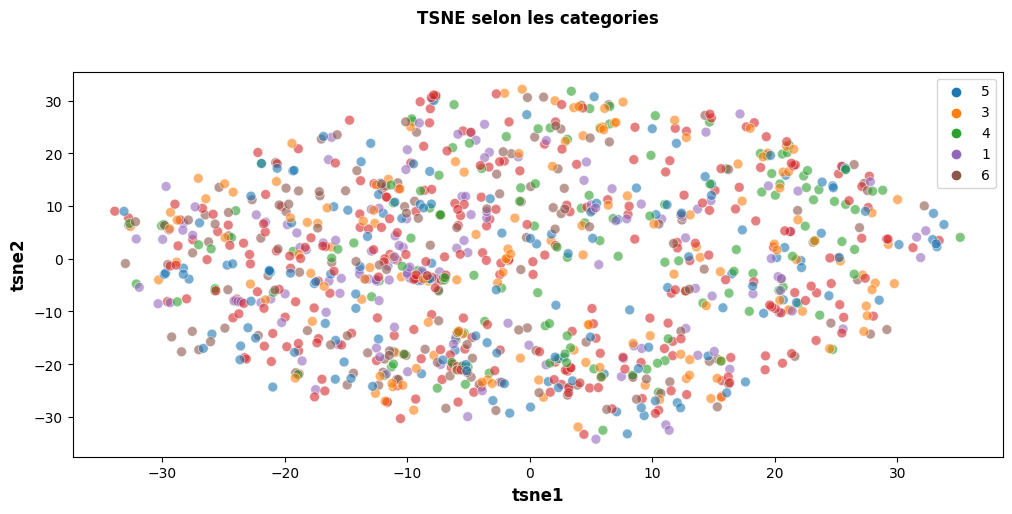

In [166]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="true_labels",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=tsne_df_copy,
    legend="brief")

plt.title('TSNE selon les categories', fontsize = 12, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 12, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 12, fontweight = 'bold')
plt.legend(prop={'size': 10}) 

plt.show()

- **Beauty and Personal Care, Home Decor & Festive Needs are missing**

- ### Kmeans

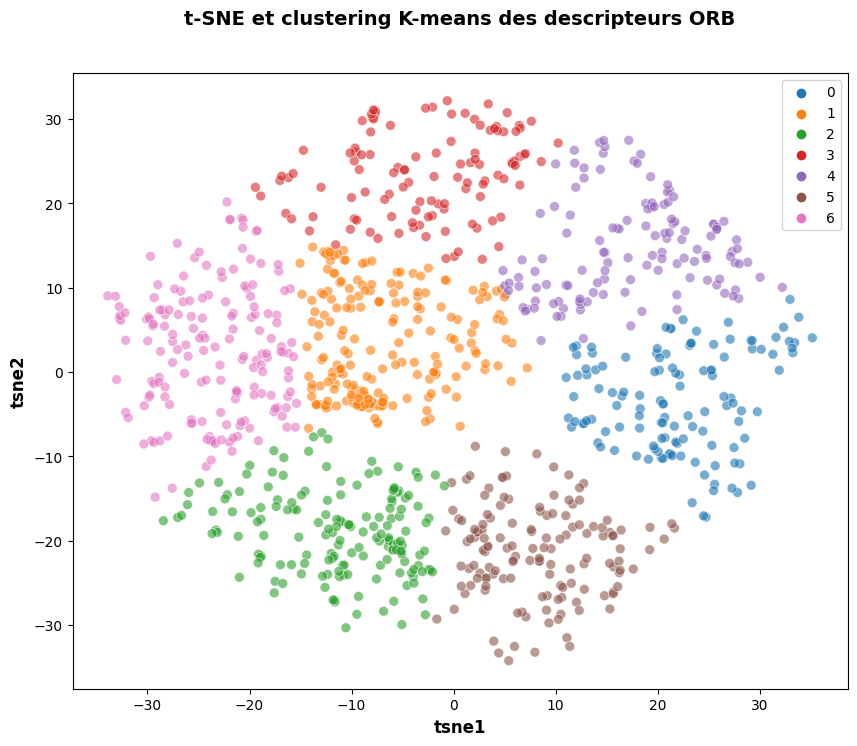

In [162]:
from sklearn.metrics import adjusted_rand_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import cluster, metrics
from sklearn.cluster import KMeans

plt.figure(figsize=(10,8))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="kmeans_labels",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=tsne_df_copy,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 12, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 12, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 12, fontweight = 'bold')
plt.title('t-SNE et clustering K-means des descripteurs ORB', fontsize = 14, pad = 35, fontweight = 'bold')

plt.legend(prop={'size': 10}) 

plt.show()


In [163]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score

# Calculer le score ARI

labels = tsne_df_copy["true_labels"]
kmeans_labels = tsne_df_copy["kmeans_labels"] 

ari = adjusted_rand_score(labels, kmeans_labels)
print("Score ARI: {:.6f}".format(ari))

Score ARI: 0.002949


# CNN (Reseau de neuronnes convolutifs)

In [19]:
# Chargement des librairies
import datetime
import sys
import time
from datetime import datetime
import jyquickhelper
import numpy as np
import pandas as pd
import os
import pickle
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Réduction dimension
from sklearn.manifold import TSNE
# Clustering
from sklearn.cluster import KMeans
# CNN Applications Keras
import keras
from keras.preprocessing import image
import tensorflow as tf
# LDA, NMF
from sklearn.decomposition import NMF, LatentDirichletAllocation

# Warnings
import warnings
warnings.filterwarnings('ignore')


### Données de travail

In [20]:
# Chargement du jeu de données
df = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

# Ajout variable images
image_path = '/Users/danongohou/Desktop/P6_Bis/Images/'
df['image_loc'] = [image_path + row for row in df['image']]

# Ajout de la variable  Categorie
df['categorie'] = df['product_category_tree'].apply(lambda x: x.split('>>')[0][2:].strip().replace('&', 'and'))
data = df[['image', 'image_loc', 'categorie']]
data.head()

,image,image_loc,categorie
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,/Users/danongohou/Desktop/P6_Bis/Images/55b85e...,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,/Users/danongohou/Desktop/P6_Bis/Images/7b72c9...,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,/Users/danongohou/Desktop/P6_Bis/Images/64d5d4...,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,/Users/danongohou/Desktop/P6_Bis/Images/d4684d...,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,/Users/danongohou/Desktop/P6_Bis/Images/6325b6...,Home Furnishing


### Création du modèle pré-entrainé

In [21]:
from keras.preprocessing import image
from keras.applications.resnet import preprocess_input
from keras.applications import ResNet152


# Instanciation du modèle
model = ResNet152(weights='imagenet', include_top=False)

# Résumé de l'architecture du modèle
model.summary()

Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                       

                                                                                                  
 conv2_block2_add (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, None, None,   0           ['conv2_block2_add[0][0]']       
                                256)                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, None, None,   16448       ['conv2_block2_out[0][0]']       
                                64)                                                               
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_2_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, None, None,   0          ['conv3_block2_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block2_2_relu[0][0]']    
                                512)                                                              
          

 conv3_block5_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block5_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block5_1_relu (Activatio  (None, None, None,   0          ['conv3_block5_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block5_2_conv (Conv2D)   (None, None, None,   147584      ['conv3_block5_1_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv3_block5_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block5_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block7_out (Activation)  (None, None, None,   0           ['conv3_block7_add[0][0]']       
                                512)                                                              
                                                                                                  
 conv3_block8_1_conv (Conv2D)   (None, None, None,   65664       ['conv3_block7_out[0][0]']       
                                128)                                                              
                                                                                                  
 conv3_block8_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block8_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_blo

 ization)                       256)                                                              
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, None, None,   0          ['conv4_block2_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block2_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block2_3_conv[0][0]']    
 ization)                       1024)                                                             
          

 conv4_block5_1_relu (Activatio  (None, None, None,   0          ['conv4_block5_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block5_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block5_2_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block5_2_relu (Activatio  (None, None, None,   0          ['conv4_block5_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block8_1_conv (Conv2D)   (None, None, None,   262400      ['conv4_block7_out[0][0]']       
                                256)                                                              
                                                                                                  
 conv4_block8_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block8_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block8_1_relu (Activatio  (None, None, None,   0          ['conv4_block8_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_blo

 lization)                      1024)                                                             
                                                                                                  
 conv4_block10_add (Add)        (None, None, None,   0           ['conv4_block9_out[0][0]',       
                                1024)                             'conv4_block10_3_bn[0][0]']     
                                                                                                  
 conv4_block10_out (Activation)  (None, None, None,   0          ['conv4_block10_add[0][0]']      
                                1024)                                                             
                                                                                                  
 conv4_block11_1_conv (Conv2D)  (None, None, None,   262400      ['conv4_block10_out[0][0]']      
                                256)                                                              
          

 conv4_block13_2_relu (Activati  (None, None, None,   0          ['conv4_block13_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block13_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block13_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block13_3_bn (BatchNorma  (None, None, None,   4096       ['conv4_block13_3_conv[0][0]']   
 lization)                      1024)                                                             
                                                                                                  
 conv4_block13_add (Add)        (None, None, None,   0           ['conv4_block12_out[0][0]',      
          

                                                                                                  
 conv4_block16_2_conv (Conv2D)  (None, None, None,   590080      ['conv4_block16_1_relu[0][0]']   
                                256)                                                              
                                                                                                  
 conv4_block16_2_bn (BatchNorma  (None, None, None,   1024       ['conv4_block16_2_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block16_2_relu (Activati  (None, None, None,   0          ['conv4_block16_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_blo

                                256)                                                              
                                                                                                  
 conv4_block19_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block19_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block19_1_relu (Activati  (None, None, None,   0          ['conv4_block19_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block19_2_conv (Conv2D)  (None, None, None,   590080      ['conv4_block19_1_relu[0][0]']   
                                256)                                                              
          

 conv4_block21_add (Add)        (None, None, None,   0           ['conv4_block20_out[0][0]',      
                                1024)                             'conv4_block21_3_bn[0][0]']     
                                                                                                  
 conv4_block21_out (Activation)  (None, None, None,   0          ['conv4_block21_add[0][0]']      
                                1024)                                                             
                                                                                                  
 conv4_block22_1_conv (Conv2D)  (None, None, None,   262400      ['conv4_block21_out[0][0]']      
                                256)                                                              
                                                                                                  
 conv4_block22_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block22_1_conv[0][0]']   
 lization)

                                                                                                  
 conv4_block24_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block24_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block24_3_bn (BatchNorma  (None, None, None,   4096       ['conv4_block24_3_conv[0][0]']   
 lization)                      1024)                                                             
                                                                                                  
 conv4_block24_add (Add)        (None, None, None,   0           ['conv4_block23_out[0][0]',      
                                1024)                             'conv4_block24_3_bn[0][0]']     
                                                                                                  
 conv4_blo

                                256)                                                              
                                                                                                  
 conv4_block27_2_bn (BatchNorma  (None, None, None,   1024       ['conv4_block27_2_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block27_2_relu (Activati  (None, None, None,   0          ['conv4_block27_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block27_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block27_2_relu[0][0]']   
                                1024)                                                             
          

 conv4_block30_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block30_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block30_1_relu (Activati  (None, None, None,   0          ['conv4_block30_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block30_2_conv (Conv2D)  (None, None, None,   590080      ['conv4_block30_1_relu[0][0]']   
                                256)                                                              
                                                                                                  
 conv4_block30_2_bn (BatchNorma  (None, None, None,   1024       ['conv4_block30_2_conv[0][0]']   
 lization)

                                                                                                  
 conv4_block32_out (Activation)  (None, None, None,   0          ['conv4_block32_add[0][0]']      
                                1024)                                                             
                                                                                                  
 conv4_block33_1_conv (Conv2D)  (None, None, None,   262400      ['conv4_block32_out[0][0]']      
                                256)                                                              
                                                                                                  
 conv4_block33_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block33_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_blo

                                1024)                                                             
                                                                                                  
 conv4_block35_3_bn (BatchNorma  (None, None, None,   4096       ['conv4_block35_3_conv[0][0]']   
 lization)                      1024)                                                             
                                                                                                  
 conv4_block35_add (Add)        (None, None, None,   0           ['conv4_block34_out[0][0]',      
                                1024)                             'conv4_block35_3_bn[0][0]']     
                                                                                                  
 conv4_block35_out (Activation)  (None, None, None,   0          ['conv4_block35_add[0][0]']      
                                1024)                                                             
          

 conv5_block2_1_relu (Activatio  (None, None, None,   0          ['conv5_block2_1_bn[0][0]']      
 n)                             512)                                                              
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, None, None,   2359808     ['conv5_block2_1_relu[0][0]']    
                                512)                                                              
                                                                                                  
 conv5_block2_2_bn (BatchNormal  (None, None, None,   2048       ['conv5_block2_2_conv[0][0]']    
 ization)                       512)                                                              
                                                                                                  
 conv5_block2_2_relu (Activatio  (None, None, None,   0          ['conv5_block2_2_bn[0][0]']      
 n)       

### Création des features

In [22]:
from PIL import Image
from tensorflow.keras.preprocessing import image
import numpy as np

# Liste des features
images_features = []

for rep_image in data['image_loc']:
   
    # Charger l'image et la redimensionner à la taille requise 
    # de 224×224 pixels.
    img = Image.open(rep_image)
    img = img.resize((224,224))

    # Convertir les pixels en un tableau NumPy afin de pouvoir 
    # travailler avec dans Keras
    img = image.img_to_array(img)
    
    # Redimensionnement
    img = np.expand_dims(img, axis=0)
    
    # Préparer de nouvelles entrées pour le réseau.
    img = preprocess_input(img)

    # obtenir une prédiction de la probabilité d'appartenance 
    # de l'image à chacun des 1000 types d'objets connus.
    pred_feature = model.predict(img)
    
    # Ajouter la feature prédite en nparray à la liste
    images_features.append(np.array(pred_feature).flatten())

images_features = np.array(images_features)


1/1 [==============================] - 0s 230ms/step


1/1 [==============================] - 0s 231ms/step


1/1 [==============================] - 0s 239ms/step


1/1 [==============================] - 0s 241ms/step


### DataFrame des vecteurs de features

In [54]:
# Vérifie si le répertoire 'sauvegarde' existe, sinon le crée
if not os.path.exists('cnn/'):
    os.makedirs('cnn/')

# Dataframe de vecteurs des features issus de ResNet152
df_features_vectors = pd.DataFrame.from_records(images_features)

# Sauvegarde du dataframe des vectors BOVW ResNet152
with open('cnn/df_features_vectors.pickle', 'wb') as f:
    pickle.dump(df_features_vectors, f, pickle.HIGHEST_PROTOCOL)

## PCA

In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Charger les descripteurs ORB extraits dans la question précédente
with open('cnn/df_features_vectors.pickle', 'rb') as f:
    df_features_vectors = pickle.load(f)

    
# Réduire la dimensionnalité avec PCA
pca = PCA(n_components=0.99)
df_pca = pca.fit_transform(df_features_vectors)

# Sauvegarde du dataframe des vectors BOVW ResNet152
with open('cnn/df_pca.pickle', 'wb') as f:
    pickle.dump(df_pca, f, pickle.HIGHEST_PROTOCOL)
    
print(df_features_vectors.shape) 
print(df_pca.shape)

(1050, 100352)
(1050, 970)


## TSNE

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1050 samples in 1.579s...
[t-SNE] Computed neighbors for 1050 samples in 6.083s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 183.127824
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.624336
[t-SNE] KL divergence after 500 iterations: 1.210239


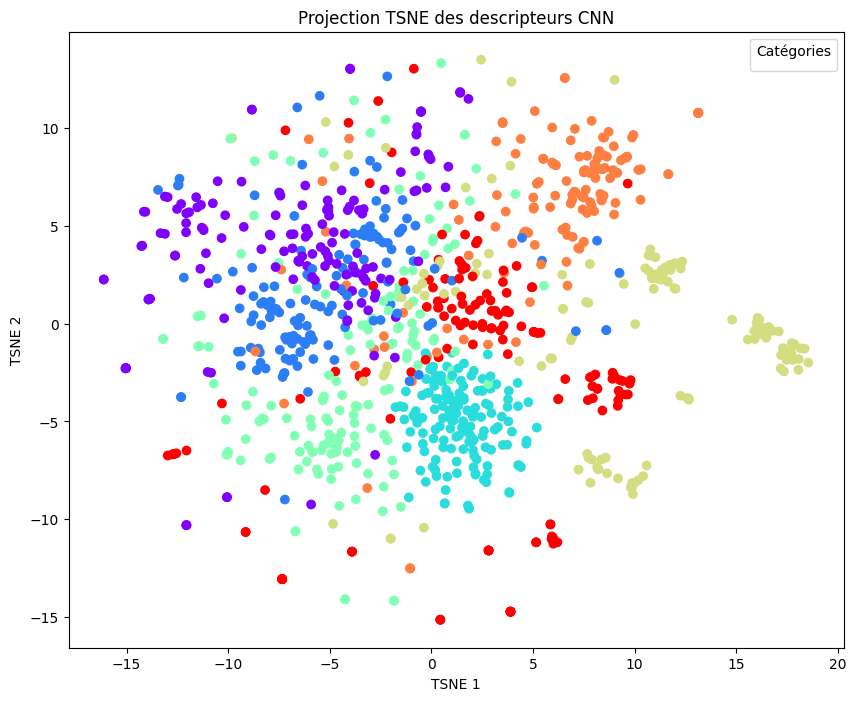

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Charger les descripteurs ORB extraits dans la question précédente
with open('cnn/df_features_vectors.pickle', 'rb') as f:
    df_features_vectors = pickle.load(f)

# Réduction de dimension tsne
tsne = TSNE(n_components=2, verbose=1, perplexity=80, n_iter=500)
X_tsne = tsne.fit_transform(df_features_vectors)

categories = data['categorie'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(categories)))
color_map = dict(zip(categories, colors))

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=data['categorie'].map(color_map))
plt.legend(*scatter.legend_elements(), title="Catégories")
plt.title("Projection TSNE des descripteurs CNN")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.show()

# Dataframe pour clustering
df_tsne = pd.DataFrame({'tsne1' : X_tsne[:, 0],
                        'tsne2' : X_tsne[:, 1],
                        'categorie' : data['categorie'],
                        'image': data['image'],
                        'image_loc': data['image_loc']})

In [56]:
df_tsne.shape

(1050, 5)

In [57]:
df_tsne.head()

,tsne1,tsne2,categorie,image,image_loc
0,-0.149491,8.662739,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg,/Users/danongohou/Desktop/P6_Bis/Images/55b85e...
1,-7.502693,6.712274,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg,/Users/danongohou/Desktop/P6_Bis/Images/7b72c9...
2,-4.534379,3.525487,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg,/Users/danongohou/Desktop/P6_Bis/Images/64d5d4...
3,-12.069267,5.148256,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg,/Users/danongohou/Desktop/P6_Bis/Images/d4684d...
4,-12.070716,4.678385,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg,/Users/danongohou/Desktop/P6_Bis/Images/6325b6...


## KMEANS

In [58]:
# Instanciation du modèle KMeans avec les meilleurs paramètres
cols = ['tsne1', 'tsne2']

kmeans_tsne = KMeans(n_clusters=7, init='k-means++', 
                     n_init=10, max_iter=200, random_state=42).fit(df_tsne[cols])

# Ajout de l'assignation du cluster au dataframe
kmeans_tsne_labels = kmeans_tsne.labels_
df_tsne['kmeans_labels'] = kmeans_tsne.labels_

In [85]:
df_tsne_copy = df_tsne.copy()
df_tsne_copy.head()

,tsne1,tsne2,categorie,image,image_loc,kmeans_labels
0,-0.149491,8.662739,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg,/Users/danongohou/Desktop/P6_Bis/Images/55b85e...,3
1,-7.502693,6.712274,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg,/Users/danongohou/Desktop/P6_Bis/Images/7b72c9...,3
2,-4.534379,3.525487,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg,/Users/danongohou/Desktop/P6_Bis/Images/64d5d4...,3
3,-12.069267,5.148256,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg,/Users/danongohou/Desktop/P6_Bis/Images/d4684d...,6
4,-12.070716,4.678385,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg,/Users/danongohou/Desktop/P6_Bis/Images/6325b6...,6


### Fonction de mapping entre clusters obetenus avec les vraies catégories

In [86]:
# Function to map predicted labels to true category names
def get_named_labels_and_num_to_name(pred_labels, true_categ_names_list):
    label_num_to_name = {} # Créer un dictionnaire vide pour stocker les noms de catégorie réelle correspondants aux labels prédits

    for pred_label in sorted(set(pred_labels)): # Boucle pour chaque label prédit unique dans la liste de labels prédits
        # Extraction des indices des éléments correspondants à ce label dans la liste "pred_labels"
        indices = [i for i in range(len(pred_labels)) if pred_labels[i] == pred_label] 

        # Extraction des noms de catégories réelles correspondants aux indices dans la liste "true_categ_names_list"
        categ_names = [true_categ_names_list[i] for i in indices] 

        # Création d'une série Pandas avec les noms de catégories réelles extraits, 
        # puis utilisation de la méthode "value_counts()" pour obtenir le nombre d'occurrences de chaque nom de catégorie réelle
        categ_name_counts = pd.Series(categ_names).value_counts() 

        # Utilisation de la méthode "idxmax()" pour obtenir le nom de catégorie réelle le plus fréquent dans la série
        most_common_categ_name = categ_name_counts.idxmax() 

        # Stockage du label prédit et du nom de catégorie réelle correspondant dans le dictionnaire "label_num_to_name"
        label_num_to_name[pred_label] = most_common_categ_name

        # Remplacement de chaque occurrence du label prédit par le nom de catégorie réelle correspondant dans la liste "pred_labels"
        pred_labels = [x if x != pred_label else most_common_categ_name for x in pred_labels]

    return label_num_to_name # Renvoi du dictionnaire "label_num_to_name" qui mappe les labels prédits aux noms de catégories réelles correspondantes



### Mapping

In [87]:
categ_names = df_tsne_copy["categorie"]
predicted_labels = df_tsne_copy['kmeans_labels']

label_num_to_name = get_named_labels_and_num_to_name(predicted_labels, categ_names)
label_num_to_name

{0: 'Computers',
 1: 'Watches',
 2: 'Beauty and Personal Care',
 3: 'Home Furnishing',
 4: 'Kitchen and Dining',
 5: 'Home Decor and Festive Needs',
 6: 'Baby Care'}

In [88]:
df = {'Computers': '0',
      'Watches': '1', 
      'Beauty and Personal Care': '2', 
      'Home Furnishing': '3', 
      'Kitchen and Dining': '4', 
      'Home Decor and Festive Needs': '5',
      'Baby Care': '6'}

df_tsne_copy['true_labels'] = df_tsne_copy['categorie'].map(df)

In [89]:
df_tsne_copy.head()

,tsne1,tsne2,categorie,image,image_loc,kmeans_labels,true_labels
0,-0.149491,8.662739,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg,/Users/danongohou/Desktop/P6_Bis/Images/55b85e...,3,3
1,-7.502693,6.712274,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg,/Users/danongohou/Desktop/P6_Bis/Images/7b72c9...,3,6
2,-4.534379,3.525487,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg,/Users/danongohou/Desktop/P6_Bis/Images/64d5d4...,3,6
3,-12.069267,5.148256,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg,/Users/danongohou/Desktop/P6_Bis/Images/d4684d...,6,3
4,-12.070716,4.678385,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg,/Users/danongohou/Desktop/P6_Bis/Images/6325b6...,6,3


### Graph TSNE selon les vraies catégories

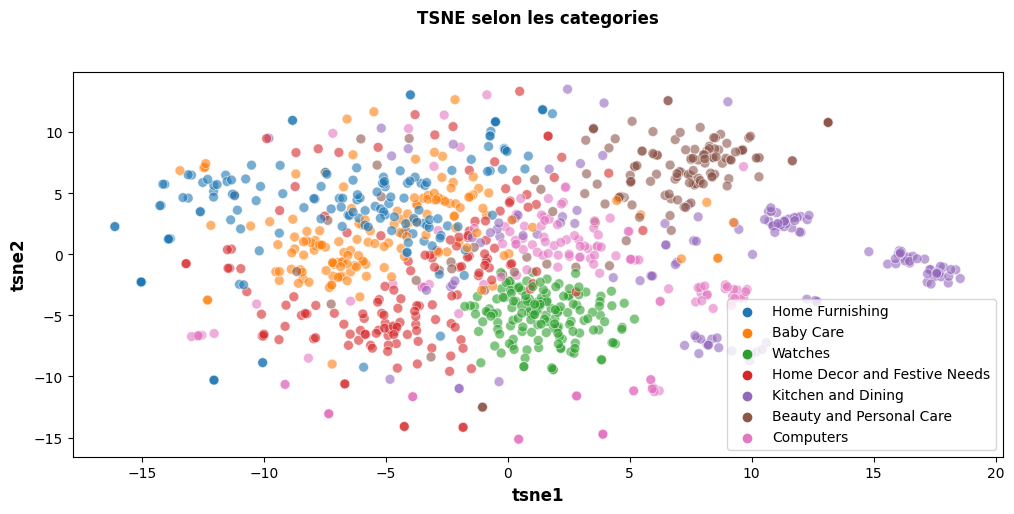

In [107]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="categorie",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne_copy,
    legend="brief")

plt.title('TSNE selon les categories', fontsize = 12, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 12, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 12, fontweight = 'bold')
plt.legend(prop={'size': 10}) 

plt.show()

### Grapgh TSNE selon les predictions KMEANS

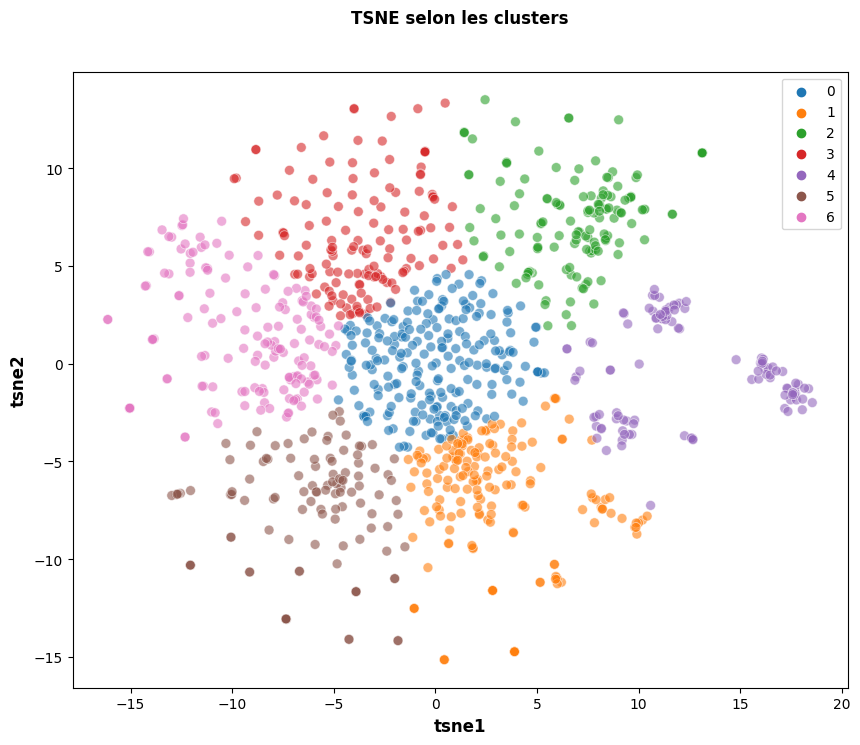

In [91]:
import pandas as pd
import numpy as np
from sklearn import cluster, metrics
from sklearn.cluster import KMeans


plt.figure(figsize=(10,8))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="kmeans_labels",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne_copy,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 12, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 12, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 12, fontweight = 'bold')
plt.legend(prop={'size': 10}) 

plt.show()

### Score ARI

In [92]:
df_tsne_copy.sample(50)

,tsne1,tsne2,categorie,image,image_loc,kmeans_labels,true_labels
952,-10.324183,4.382596,Home Furnishing,5be86e35f21b1514d0e7742893d6cfba.jpg,/Users/danongohou/Desktop/P6_Bis/Images/5be86e...,6,3
426,0.042820,0.037740,Baby Care,70461caa9038cfa34d109ea056d57f5a.jpg,/Users/danongohou/Desktop/P6_Bis/Images/70461c...,0,6
479,5.220390,-0.476044,Computers,209bf06a732416f1ce5147a8b0524808.jpg,/Users/danongohou/Desktop/P6_Bis/Images/209bf0...,0,0
532,1.618922,-5.514043,Watches,64247967cbf6cd8bb2e243ac53aa5928.jpg,/Users/danongohou/Desktop/P6_Bis/Images/642479...,1,1
554,2.591855,-5.486324,Watches,b144a363c107c7bdd91f32d6e28ba6f2.jpg,/Users/danongohou/Desktop/P6_Bis/Images/b144a3...,1,1
746,-5.031821,5.524368,Home Furnishing,037c2402fee39fbc80433935711d1383.jpg,/Users/danongohou/Desktop/P6_Bis/Images/037c24...,3,3
147,17.601954,-1.459295,Kitchen and Dining,f8794f7a06b530782c66f7c0911bb437.jpg,/Users/danongohou/Desktop/P6_Bis/Images/f8794f...,4,4
197,6.481688,0.761568,Kitchen and Dining,e3c741a05c82c54343b94ed8c1292e2a.jpg,/Users/danongohou/Desktop/P6_Bis/Images/e3c741...,4,4
389,9.523873,8.474751,Beauty and Personal Care,51dc964c7a47293ff0ed0c6912813722.jpg,/Users/danongohou/Desktop/P6_Bis/Images/51dc96...,2,2
244,9.919333,-8.714375,Kitchen and Dining,0c4718ae90f2889b7021a99ee1cc106c.jpg,/Users/danongohou/Desktop/P6_Bis/Images/0c4718...,1,4


In [93]:
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import cluster, metrics

true_labels = df_tsne_copy['true_labels']
kmeans_labels = df_tsne_copy['kmeans_labels']

ari = adjusted_rand_score(true_labels, kmeans_labels) 
print("ARI :", ari) 


ARI : 0.3216084682396735


## Analyse des class

In [94]:
df_tsne_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tsne1          1050 non-null   float32
 1   tsne2          1050 non-null   float32
 2   categorie      1050 non-null   object 
 3   image          1050 non-null   object 
 4   image_loc      1050 non-null   object 
 5   kmeans_labels  1050 non-null   int32  
 6   true_labels    1050 non-null   object 
dtypes: float32(2), int32(1), object(4)
memory usage: 45.2+ KB


In [96]:
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve

df_tsne_copy['true_labels'] = df_tsne_copy['true_labels'].astype('int32')


true_labels = df_tsne_copy['true_labels']
kmeans_labels = df_tsne_copy['kmeans_labels']

conf_mat = metrics.confusion_matrix(true_labels, kmeans_labels)
print(conf_mat)

[[ 70  29   3   6  21  21   0]
 [ 35 115   0   0   0   0   0]
 [ 16   3 120   6   0   2   3]
 [ 17   0   4  64   0   7  58]
 [ 20  24   9   5  89   3   0]
 [ 41   1   6  14   0  75  13]
 [ 21   0   3  43   4   2  77]]


In [97]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']


In [99]:
cls_labels_transform = conf_mat_transform(true_labels, kmeans_labels)
conf_mat = metrics.confusion_matrix(true_labels, cls_labels_transform)
print(conf_mat)
print() 
print(metrics.classification_report(true_labels, cls_labels_transform))


Correspondance des clusters :  [0 1 2 3 4 5 6]
[[ 70  29   3   6  21  21   0]
 [ 35 115   0   0   0   0   0]
 [ 16   3 120   6   0   2   3]
 [ 17   0   4  64   0   7  58]
 [ 20  24   9   5  89   3   0]
 [ 41   1   6  14   0  75  13]
 [ 21   0   3  43   4   2  77]]

              precision    recall  f1-score   support

           0       0.32      0.47      0.38       150
           1       0.67      0.77      0.71       150
           2       0.83      0.80      0.81       150
           3       0.46      0.43      0.44       150
           4       0.78      0.59      0.67       150
           5       0.68      0.50      0.58       150
           6       0.51      0.51      0.51       150

    accuracy                           0.58      1050
   macro avg       0.61      0.58      0.59      1050
weighted avg       0.61      0.58      0.59      1050



In [ ]:
 Par exemple, pour la classe 0, le modèle a prédit correctement 70 
    instances de la classe 0 (vrai positif), a prédit à tort 29 
    instances de la classe 0 comme appartenant à d'autres classes 
    (faux positifs), et a prédit à tort 21 instances appartenant à d'autres 
    classes comme appartenant à la classe 0 (faux négatifs).

<Axes: >

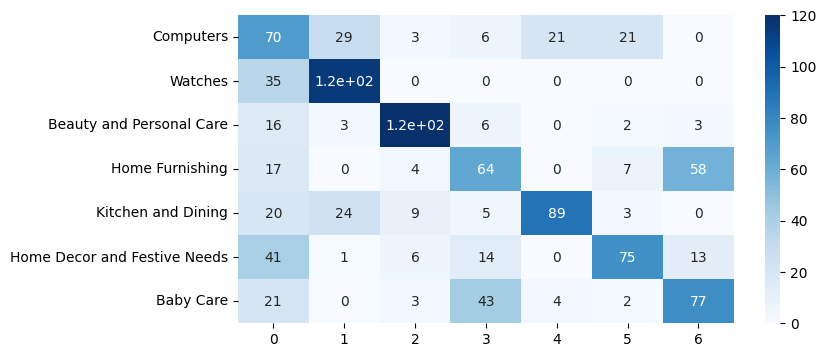

In [103]:

list_labels = ['Computers','Watches', 'Beauty and Personal Care', 
               'Home Furnishing', 'Kitchen and Dining', 
               'Home Decor and Festive Needs','Baby Care']

df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (8,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")